In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [188]:
%matplotlib inline
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression, make_classification, make_blobs
from sklearn.decomposition import PCA
from sklearn import preprocessing

from multiprocessing import Pool
from functools import partial

from CrossValidation import *
from FeatureSimilarity import GetTopGenes
from MatrixFactorization import CreateLatentVariables, FactorizeMatrix, GetRepresentationError

from utils import *

In [189]:
n = 500
g = 2000
k = 20
o = 1
avgGenesInPath = 50

In [190]:
def DatasetToDF(X, binaryPathwayMatrix, phenotypeGenes):
    df = pd.DataFrame(X.T)
    is_gene = np.ones(g)
    is_gene[0] = 0
    phenotype_gene_col = np.zeros(g)
    phenotype_gene_col[phenotypeGenes] = 1
    
    df['is_gene'] = is_gene
    df['phenotype_genes'] = phenotype_gene_col
    
    df = pd.concat([df, pd.DataFrame(binaryPathwayMatrix, columns=['pathway{}'.format(i) for i in range(binaryPathwayMatrix.shape[1])])], axis=1)
    return df

def DFtoDataset(df, scale=False):
    X = df[np.arange(n)].values.T
    if (scale):
        X = preprocessing.scale(X)
        
    binaryPathwayMatrix = df[['pathway{}'.format(i) for i in range(df.shape[1] - n - 2)]].values

    phenotypeGenes = df['phenotype_genes']
    phenotypeGenes = np.where(phenotypeGenes == 1)[0]

    return X, binaryPathwayMatrix, phenotypeGenes

In [191]:
U, V, binaryPathwayMatrix, phenotypeGenes = GenerateSimulatedData(n, g, k, avgGenesInPath)
X = np.dot(U, V.T)

In [192]:
df = DatasetToDF(X, binaryPathwayMatrix, phenotypeGenes)

In [193]:
X_rec, bin_rec, phe_rec = DFtoDataset(df)

In [194]:
assert np.all(X_rec == X)
assert np.all(np.sort(phe_rec) == np.sort(phenotypeGenes))
assert np.all(bin_rec == binaryPathwayMatrix)

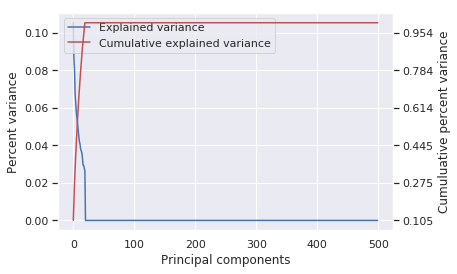

In [195]:
ScreePlot(X.T)

In [196]:
pca = PCA(n_components=50)
projectedX = pca.fit_transform(X.T)
latent_dim = np.min(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0])
latent_dim

18

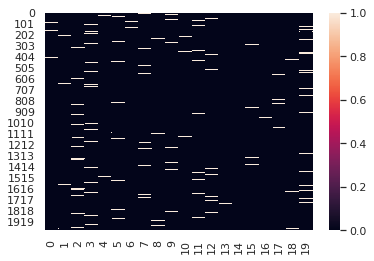

In [197]:
sns.heatmap(binaryPathwayMatrix)

In [198]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsneProjectedX = tsne.fit_transform(projectedX)

In [199]:
inPathway = ['p{}'.format(i) for i in binaryPathwayMatrix[:, 0]]

In [211]:
np.sort(phenotypeGenes)

array([   0,   22,   91,   93,  131,  146,  156,  166,  233,  389,  415,
        480,  591,  745,  988, 1010, 1101, 1120, 1410, 1587, 1676, 1692,
       1759, 1890, 1939])

In [241]:
geneMat = np.zeros(g) - 1

In [242]:
isInPath = np.sum(binaryPathwayMatrix, axis=1) > 0
geneMat[isInPath] = np.where(binaryPathwayMatrix > 0)[1]

In [243]:
phenotype_gene_col = np.zeros(g)
phenotype_gene_col[phenotypeGenes] = 1
df2 = pd.DataFrame({
    'tsne1': tsneProjectedX[:, 0],
    'tsne2': tsneProjectedX[:, 1],
    'pathway': ['p{}'.format(i) for i in geneMat] #binaryPathwayMatrix[:, 4]]#phenotype_gene_col]
})

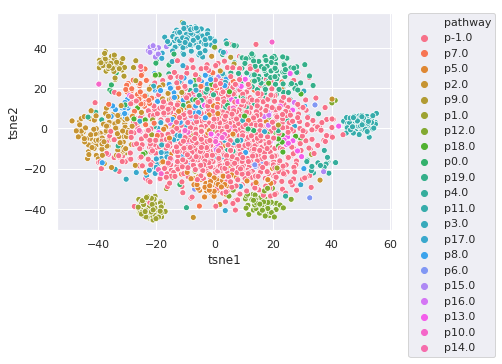

In [244]:
sns.scatterplot(x='tsne1', y='tsne2', hue='pathway', data=df2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)